<a href="https://colab.research.google.com/github/limshaocong/analyticsEdge/blob/main/FAANG_Volume_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preliminaries**

In [85]:
suppressMessages(library(tidyverse)) # generic must have package
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2)) # plotting package
suppressMessages(library(lubridate)) # easy comprehension of dates from string to correct datetime format
suppressMessages(library(data.table))
suppressMessages(library(purrr)) # reduce
if("patchwork" %in% rownames(installed.packages()) == FALSE) {install.packages("patchwork")}
suppressMessages(library(patchwork))
if("caret" %in% rownames(installed.packages()) == FALSE) {install.packages("caret")}
suppressMessages(library(caret))

options(repr.plot.width = 10,
        repr.plot.height = 9,
        repr.plot.pointsize = 20)

Import data and check for any NA within the file

In [149]:
path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/FAANG/altdata.csv"
df = read.csv(path) %>% mutate(date = mdy(date))

if (dim(df)[1] == dim(na.omit(df))[1]) {
  print("No missing data.")
} else {
  print("Missing data")
}

[1] "No missing data."


In [196]:
head(df)

,ticker,date,low,high,close,open,vol,newssentiment,newsmentions,twtrmentions,twtrsentiment,wsbmentions,wsbsentiment,otcvol,otcshortvol,pricetarget,voltarget
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,FB,2019-01-02,128.56,137.51,135.68,128.99,28142593,50,2,606,0.11716172,20,0.1814700,6613580,2628392,131.74,22716248
2,FB,2019-01-03,131.12,137.17,131.74,134.69,22716248,50,0,521,0.03071017,14,-0.1376714,4569885,1702153,137.95,29000732
3,FB,2019-01-04,133.75,138.00,137.95,134.01,29000732,50,0,431,0.05800464,10,-0.0623300,4911618,2128652,138.05,20088916
4,FB,2019-01-07,135.91,138.87,138.05,137.56,20088916,50,0,415,0.20240964,6,-0.2222167,4584625,1587876,142.53,26252863
5,FB,2019-01-08,139.54,143.14,142.53,139.89,26252863,63,2,569,0.26889279,6,0.3528667,9785909,3604629,144.23,22203279
6,FB,2019-01-09,141.27,144.70,144.23,142.95,22203279,50,0,489,0.09406953,1,-0.3818000,5669715,2264483,144.20,16111304


# **Exploratory Analysis**

Overview of Data

In [ ]:
head(df, 5)

,ticker,date,low,high,close,open,vol,newssentiment,newsmentions,twtrmentions,twtrsentiment,wsbmentions,wsbsentiment,pricetarget,voltarget
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,FB,2019-01-02,128.56,137.51,135.68,128.99,28142593,50,2,606,0.11716172,20,0.1814700,131.74,22716248
2,FB,2019-01-03,131.12,137.17,131.74,134.69,22716248,50,0,521,0.03071017,14,-0.1376714,137.95,29000732
3,FB,2019-01-04,133.75,138.00,137.95,134.01,29000732,50,0,431,0.05800464,10,-0.0623300,138.05,20088916
4,FB,2019-01-07,135.91,138.87,138.05,137.56,20088916,50,0,415,0.20240964,6,-0.2222167,142.53,26252863
5,FB,2019-01-08,139.54,143.14,142.53,139.89,26252863,63,2,569,0.26889279,6,0.3528667,144.23,22203279


504 trading days worth of training data from 2019 to 2020.

In [ ]:
df %>%
  group_by(ticker) %>%
  summarise(n())

ticker,n()
<chr>,<int>
AAPL,504
AMZN,504
FB,504
GOOGL,504
NFLX,504


Plotting sentiment and changes in closing price

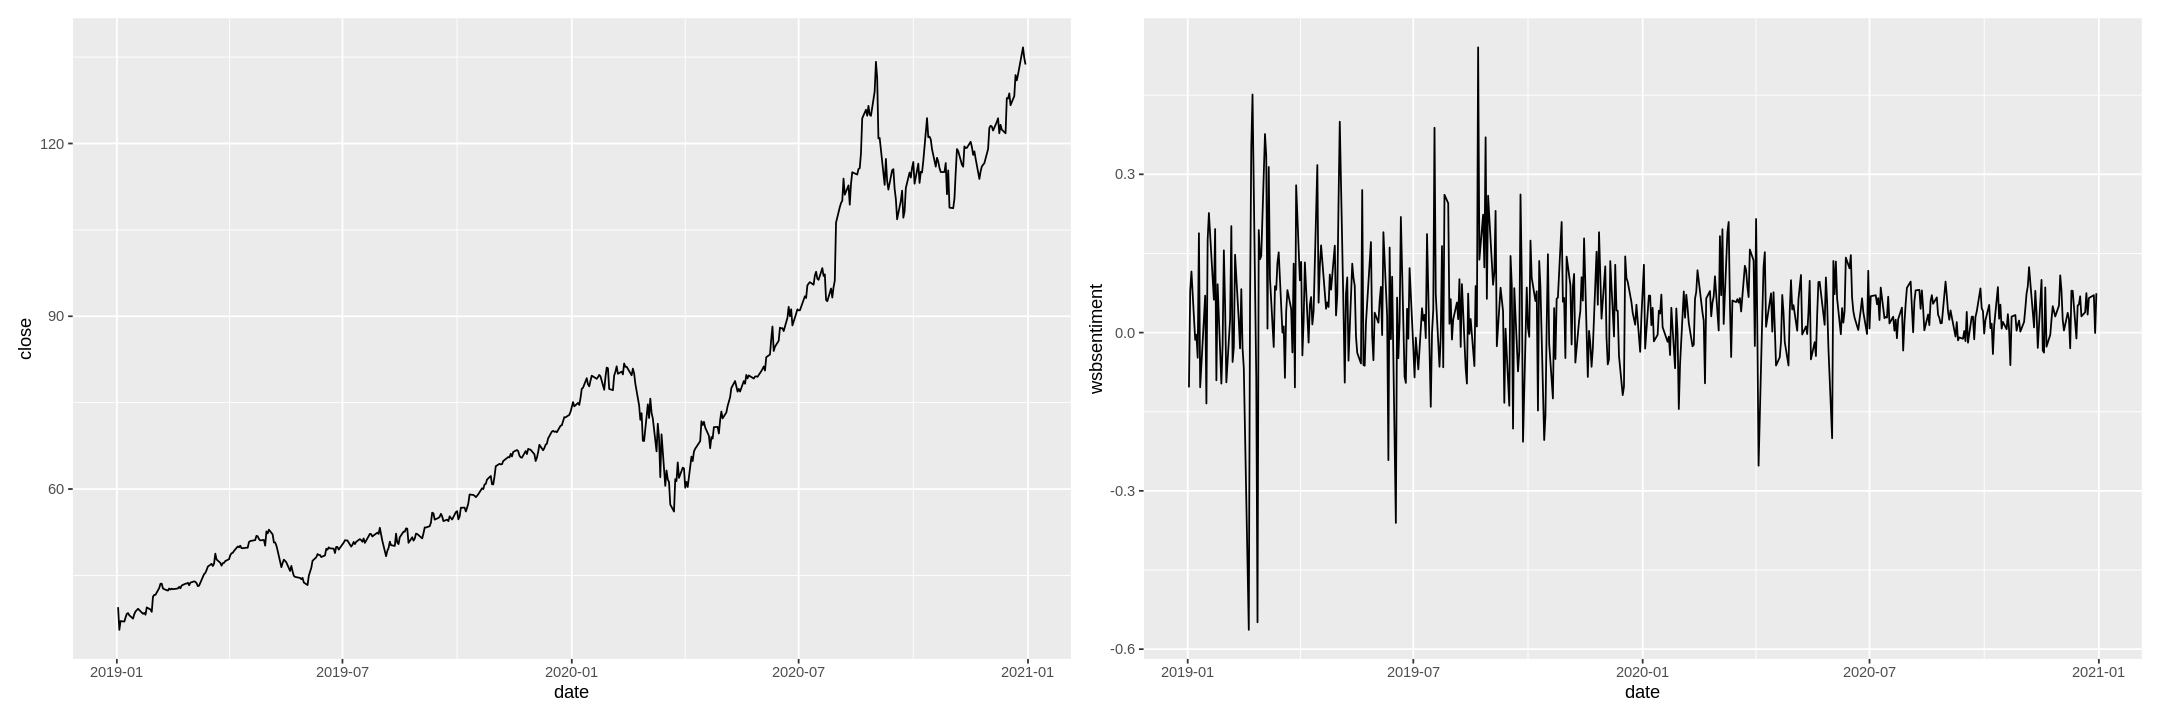

In [ ]:
p1 = df %>%
      filter(ticker == "AAPL") %>%
      ggplot() +
      geom_line(aes(x = date, y = close)) 

p2 = df %>%
      filter(ticker == "AAPL") %>%
      ggplot(aes(x = date)) +
      geom_line(aes(y = wsbsentiment)) 

p1
p2

# **Data Preparation**

Train-test split

In [152]:
split = as.Date("2020-06-30")

# Train-test split
train = df %>% filter(date < split)
test = df %>% filter(date >= split)

train_days = dim(train)[1]/5
test_days = dim(test)[1]/5

train_prop = train_days / (train_days + test_days)

paste0("Training data proportion: ", round(train_prop * 100, 1), "%. Total training days = ", train_days)

[1] "Training data proportion: 74.6%. Total training days = 376"

Train-validate Split - as normal k-fold CV does not work on time series, an expanding window approach is used (see Section 4.3 of https://topepo.github.io/caret/data-splitting.html#time). With these parameters, CV-error will be run on 5 different validation sets.

In [34]:
index = 1:train_days
slices = createTimeSlices(index, initialWindow = 130, horizon = 30, fixedWindow = FALSE, skip = 40)

trainslices = slices[[1]] # specific slices callable by df[trainslices[[i]],]
testslices = slices[[2]]

lapply(slices, length)

$train
[1] 6

$test
[1] 6

# **Model Building**

In [170]:
suppressMessages(library(rpart.plot))
if("Metrics" %in% rownames(installed.packages()) == FALSE) {install.packages("Metrics")}
suppressMessages(library(Metrics))
if("glm2" %in% rownames(installed.packages()) == FALSE) {install.packages("glm2")}
suppressMessages(library(glm2))
if("xgboost" %in% rownames(installed.packages()) == FALSE) {install.packages("xgboost")}
library(xgboost)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [202]:
# Function to construct CART tree
cart = function() {
  
  train_control = trainControl(method = "timeslice",
                            initialWindow = 130,
                            horizon = 30,
                            fixedWindow = FALSE,
                            skip = 40,
                            savePredictions = TRUE)

  # hyperparameters
  cp_values = data.frame(.cp = seq(0, 0.01, by = 0.0001))

  model = train(x = trainX,
                y = trainY,
                method = "rpart",
                trControl = train_control,
                tuneGrid = cp_values)

}

# Function to construct RandomForest
randomforest = function() {

  train_control = trainControl(method = "timeslice",
                                initialWindow = 130,
                                horizon = 30,
                                fixedWindow = FALSE,
                                skip = 40,
                                savePredictions = TRUE)

  # hyperparameters
  n_pred = dim(trainX)[2]
  mtry_low = 1
  mtry_upp = n_pred - 1
  mtry_grid = data.frame(mtry = seq(mtry_low, mtry_upp, by = 1))
      
  model = train(x = trainX,
                y = trainY,
                method = "rf",
                trControl = train_control,
                tuneGrid = mtry_grid,
                ntree = 150,
                nodesize = 5)

}

# Function to construct XGBoost
xgb = function() {
  
  train_control = trainControl(method = "timeslice",
                              initialWindow = 130,
                              horizon = 30,
                              fixedWindow = FALSE,
                              skip = 40,
                              savePredictions = TRUE,
                              allowParallel = TRUE)

  # hyperparameters that require further tuning
  parm_grid = expand.grid(nrounds = 100, 
                          max_depth = 6, 
                          eta = seq(0.01, 0.05, by = 0.001),
                          gamma = 0,
                          colsample_bytree = 1,
                          min_child_weight = 1,
                          subsample = c(0.3, 0.5))

  model = train(x = trainX,
                y = trainY,
                method = "xgbTree",
                tuneGrid = parm_grid,
                trControl = train_control)

}

# Function to plot 
plotlastfold = function(model) {
  
  train_pred = predict(model$finalModel, newdata = trainX)
  
  model_df = data.frame(timesteps = seq(1, train_days), predicted = train_pred, actual = trainY)

  ggplot(data = model_df, (aes(x = timesteps))) +
    geom_line(aes(y = predicted), color = "blue") +
    geom_line(aes(y = actual), color = "black")

}


In [198]:
tick = "AAPL"

trainX = train %>% filter(ticker == tick) %>% select(c(7:15))
trainY = train %>% filter(ticker == tick) %>% select(c(17)) %>% pull()

testX = test %>% filter(ticker == tick) %>% select(c(7:15))
testY = test %>% filter(ticker == tick) %>% select(c(17)) %>% pull()

In [200]:
# Construct a CART tree
tree = cart()

# cp= 0.0007 gives the lowest CV RMSE
tree$results %>% arrange(RMSE) %>% head()

,cp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7e-04,2927240,0.2127140,2234905,1627863,0.2082261,1207562
2,8e-04,2927240,0.2127140,2234905,1627863,0.2082261,1207562
3,0e+00,2928267,0.2117028,2236432,1627249,0.2084203,1206755
4,1e-04,2928267,0.2117028,2236432,1627249,0.2084203,1206755
5,2e-04,2928267,0.2117028,2236432,1627249,0.2084203,1206755
6,3e-04,2928267,0.2117028,2236432,1627249,0.2084203,1206755


In [203]:
# Construct a RandomForest
forest = randomforest()

# mtry = 6 gives the lowest CV RMSE
forest$results %>% arrange(RMSE) %>% head()

mtry,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,2466002,0.2939868,1867399,1174385,0.1876427,755612.2
7,2474914,0.2843725,1871015,1222379,0.1827553,791962.5
8,2487624,0.2836603,1901819,1171751,0.1847954,792465.7
4,2496128,0.2771847,1890202,1139840,0.1942951,760238.7
5,2503157,0.2783119,1891141,1179127,0.1886365,771827.9
2,2540587,0.2667488,1931056,1234808,0.1914192,833709.6
3,2541207,0.2712813,1933652,1238154,0.1608600,827965.9
1,2673128,0.2624575,2093825,1532242,0.1920181,1175744.0


In [205]:
# Construct a XGBoost
xgboost = xgb()

#xgboost$bestTune

# The above parameters gives the lowest CV RMSE
# xgBoost requires far more tuning
# The current tuning grid is too small to explore the solution space fully
xgboost$results %>% arrange(RMSE) %>% head()

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
81,100,6,0.05,0,1,1,0.3


,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.050,6,0,1,1,0.3,100,2557549,0.2992855,1959636,1295315,0.1766800,972323.8
2,0.049,6,0,1,1,0.3,100,2558867,0.2816140,1956604,1183830,0.2118262,913518.6
3,0.043,6,0,1,1,0.3,100,2582972,0.2940407,2014520,1382888,0.2156231,1144757.2
4,0.047,6,0,1,1,0.5,100,2588562,0.2810817,2002828,1306722,0.1852627,1012252.1
5,0.047,6,0,1,1,0.3,100,2590745,0.2894516,1983579,1228978,0.1990976,982851.3
6,0.049,6,0,1,1,0.5,100,2593936,0.2855661,1972655,1391503,0.1550431,1039660.1
